In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
flag = True  # Set this flag as needed
name = "Preprocessed_Data.csv" if flag == True else "Mall_Customers.csv"
df = pd.read_csv(name)
if name == "Mall_Customers.csv":
    df = df.drop(columns=['CustomerID'])
    df['Genre'] = df['Genre'].map({'Male': 1, 'Female': 0})
    ss = StandardScaler()
    df[ df.columns ] = ss.fit_transform( df[ df.columns ] )
df.head()

,Annual Income (k$),Annual Income (k$) Spending Score (1-100),Genre,Income_per_Age,Spending Score (1-100)
0,-1.738999,-1.077128,1,-1.010344,-0.434801
1,-1.738999,-0.801479,1,-1.089296,1.195704
2,-1.700830,-1.291084,0,-0.999291,-1.715913
3,-1.700830,-0.794041,0,-1.108862,1.040418
4,-1.662660,-1.035562,0,-1.263499,-0.395980


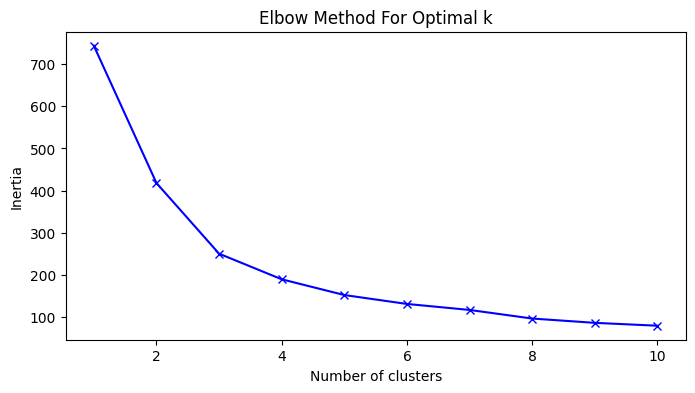

In [55]:
# get number of clusters using elbow method
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

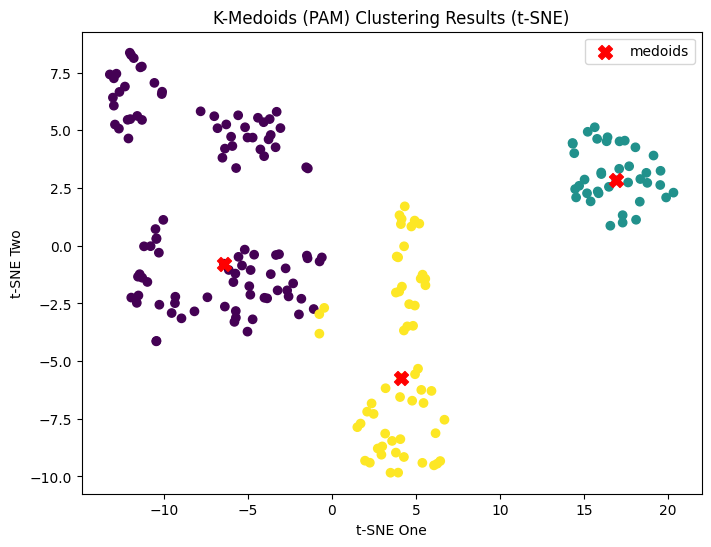

In [56]:
# clustering by k-medoids (PAM) - pure-Python implementation to avoid sklearn_extra binary dependency
from sklearn.metrics import pairwise_distances
import numpy as np

def kmedoids_pam(X, n_clusters, max_iter=300, random_state=42):
    """PAM (Partitioning Around Medoids) with KMeans++-style initialization."""
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]
    # full pairwise distance matrix (Euclidean)
    D = pairwise_distances(X, metric='euclidean')

    def init_medoids_kpp(D, k, rng):
        """KMeans++-like initialization for medoids using distance matrix D."""
        n = D.shape[0]
        medoids = []
        # pick first medoid uniformly
        first = int(rng.integers(0, n))
        medoids.append(first)
        # pick remaining medoids
        for _ in range(1, k):
            # distance from each point to the nearest chosen medoid
            dist_to_nearest = np.min(D[:, medoids], axis=1)
            # squared distances (kmeans++ uses squared distances)
            probs = dist_to_nearest ** 2
            total = probs.sum()
            if total <= 0:
                # all distances zero -> pick randomly among remaining
                candidates = [i for i in range(n) if i not in medoids]
                if not candidates:
                    break
                next_medoid = int(rng.choice(candidates))
            else:
                probs = probs / total
                probs[medoids] = 0.0
                psum = probs.sum()
                if psum <= 0:
                    candidates = [i for i in range(n) if i not in medoids]
                    next_medoid = int(rng.choice(candidates))
                else:
                    next_medoid = int(rng.choice(n, p=probs))
            medoids.append(next_medoid)
        return np.array(medoids, dtype=int)

    # initialize medoids with kmeans++-like method
    medoids = init_medoids_kpp(D, n_clusters, rng)
    labels = np.argmin(D[:, medoids], axis=1)

    for _ in range(max_iter):
        changed = False
        for i in range(n_clusters):
            cluster_idx = np.where(labels == i)[0]
            if len(cluster_idx) == 0:
                continue
            # compute total distance for each candidate medoid inside the cluster
            subD = D[np.ix_(cluster_idx, cluster_idx)]
            costs = subD.sum(axis=1)
            new_medoid_local = cluster_idx[np.argmin(costs)]
            if new_medoid_local != medoids[i]:
                medoids[i] = new_medoid_local
                changed = True
        labels = np.argmin(D[:, medoids], axis=1)
        if not changed:
            break
    return medoids, labels

# prepare data and run K-Medoids on 2D PCA projection
data_kmedoids = df.copy()  # already preprocessed
kmedoids_n = 3
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_kmedoids)
data_kmedoids['tsne-one'] = tsne_result[:, 0]
data_kmedoids['tsne-two'] = tsne_result[:, 1]
X = data_kmedoids[['tsne-one', 'tsne-two']].values
medoids, labels = kmedoids_pam(X, n_clusters=kmedoids_n, random_state=42)
data_kmedoids['kmedoids_cluster'] = labels
plt.figure(figsize=(8, 6))
plt.scatter(data_kmedoids['tsne-one'], data_kmedoids['tsne-two'], c=data_kmedoids['kmedoids_cluster'], cmap='viridis')
# mark medoids
plt.scatter(X[medoids, 0], X[medoids, 1], c='red', marker='X', s=100, label='medoids')
plt.title('K-Medoids (PAM) Clustering Results (t-SNE)')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.legend()
plt.show()

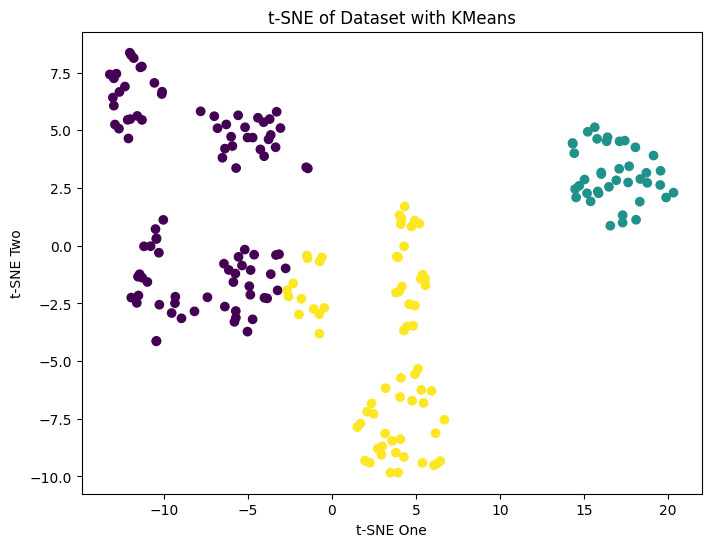

In [57]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

data_kmeans = df.copy() # already preprocessed
# apply clustering algorithm
Kmeans = KMeans(n_clusters=3, random_state=42)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_kmeans)
data_kmeans['tsne-one'] = tsne_result[:,0]
data_kmeans['tsne-two'] = tsne_result[:,1]
data_kmeans['cluster'] = Kmeans.fit_predict(data_kmeans[['tsne-one', 'tsne-two']])
plt.figure(figsize=(8,6))
plt.scatter(data_kmeans['tsne-one'], data_kmeans['tsne-two'], c=data_kmeans['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with KMeans')
plt.show()

/tmp/ipykernel_2448/2948988032.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


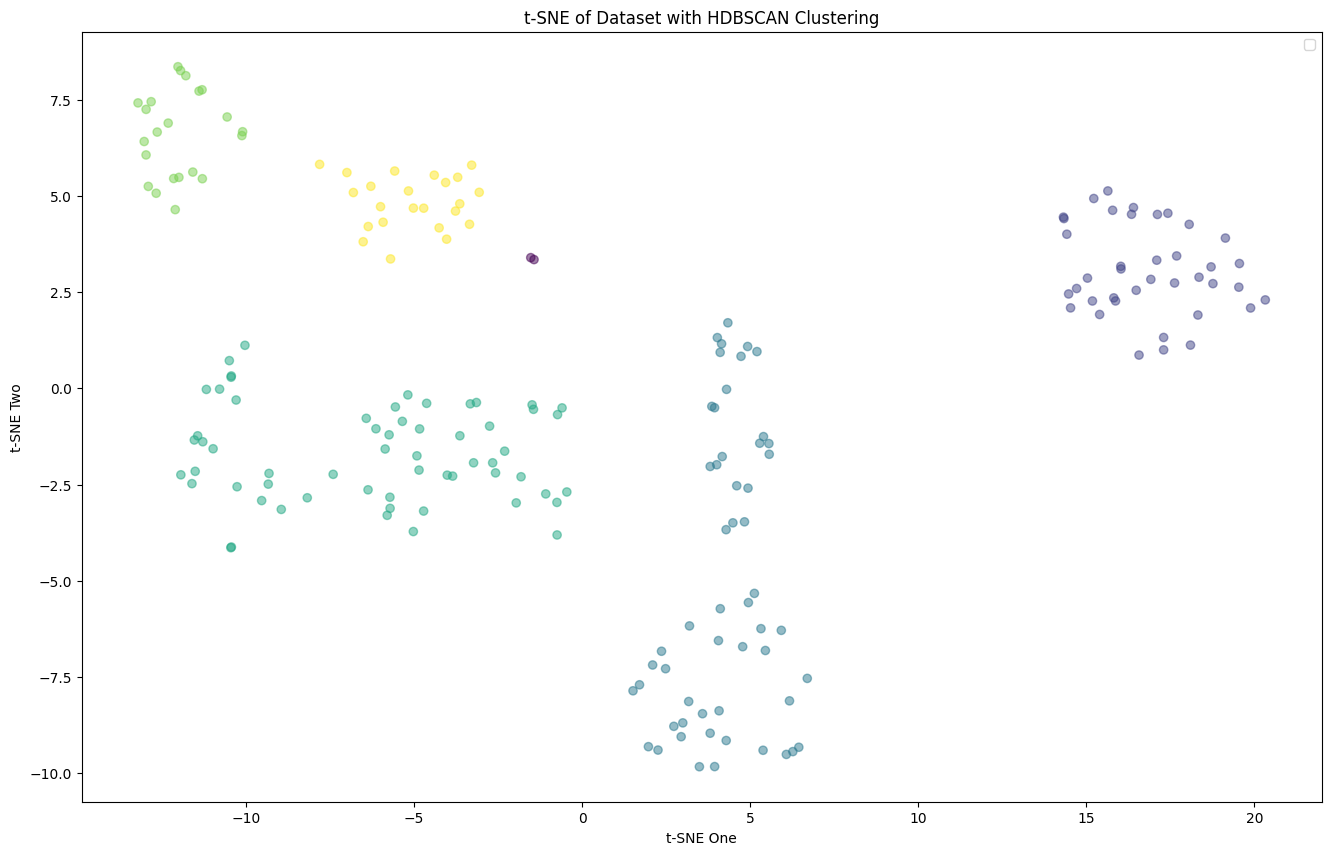

In [58]:
from sklearn.cluster import HDBSCAN
# import tSNE
from sklearn.manifold import TSNE
hdbscan_model = HDBSCAN(min_cluster_size=10)
data_hdbscan = df.copy() # already preprocessed
# apply clustering algorithm
tsne = TSNE(n_components=2, random_state=42)
tsne_result_hdbscan = tsne.fit_transform(data_hdbscan)
data_hdbscan['tsne-one'] = tsne_result_hdbscan[:,0]
data_hdbscan['tsne-two'] = tsne_result_hdbscan[:,1]
data_hdbscan['cluster'] = hdbscan_model.fit_predict(data_hdbscan[['tsne-one','tsne-two']])
plt.figure(figsize=(16,10))
plt.scatter(data_hdbscan['tsne-one'], data_hdbscan['tsne-two'], alpha=0.5, c=data_hdbscan['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with HDBSCAN Clustering')
plt.legend()
plt.show()

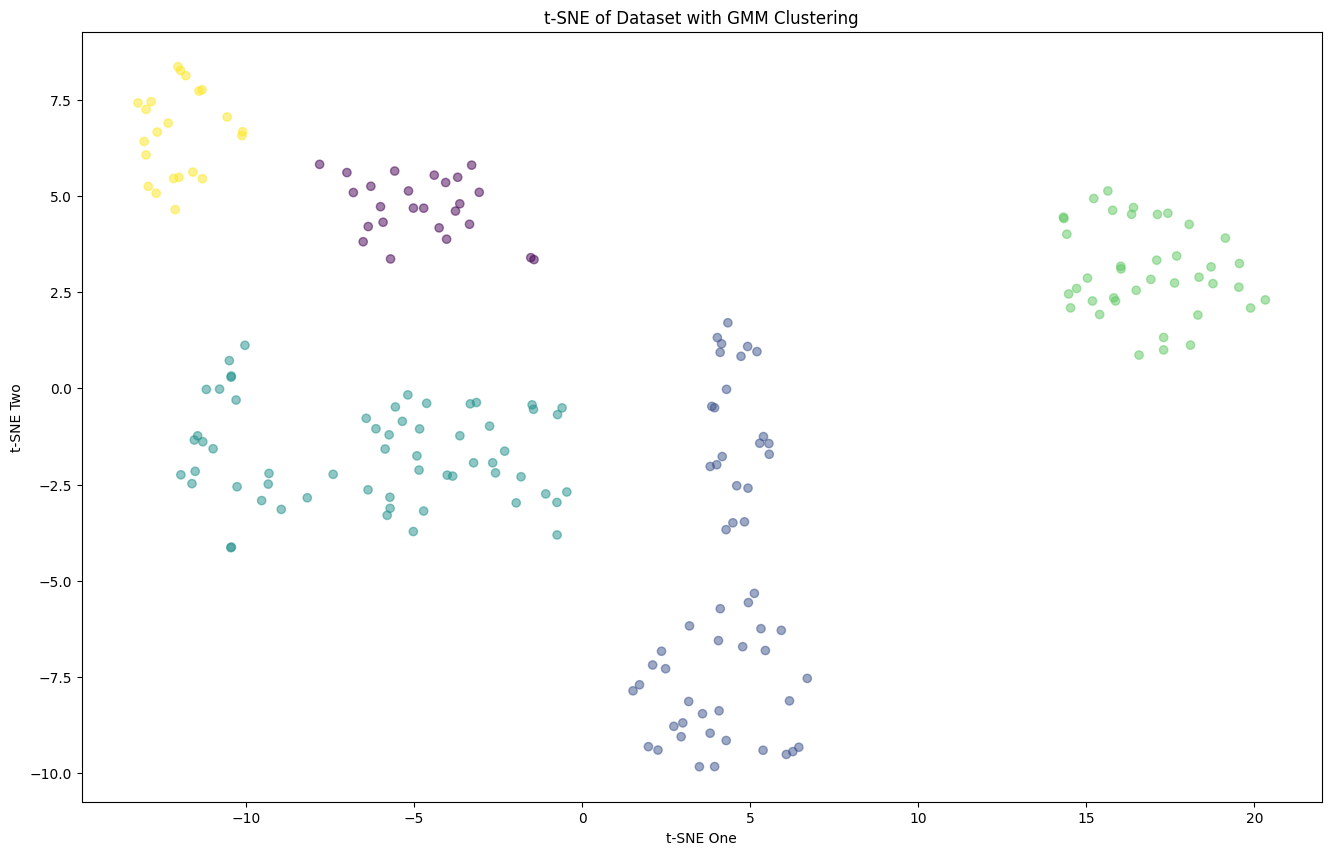

In [59]:
from sklearn.mixture import GaussianMixture
data_gmm = df.copy() # already preprocessed
# apply clustering algorithm
gmm = GaussianMixture(n_components=5, random_state=42)
tsne = TSNE(n_components=2, random_state=42)
tsne_result_gmm = tsne.fit_transform(data_gmm)
data_gmm['tsne-one'] = tsne_result_gmm[:,0]
data_gmm['tsne-two'] = tsne_result_gmm[:,1]
data_gmm['cluster'] = gmm.fit_predict(data_gmm[['tsne-one','tsne-two']])
plt.figure(figsize=(16,10))
plt.scatter(data_gmm['tsne-one'], data_gmm['tsne-two'], alpha=0.5, c=data_gmm['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with GMM Clustering')
plt.show()

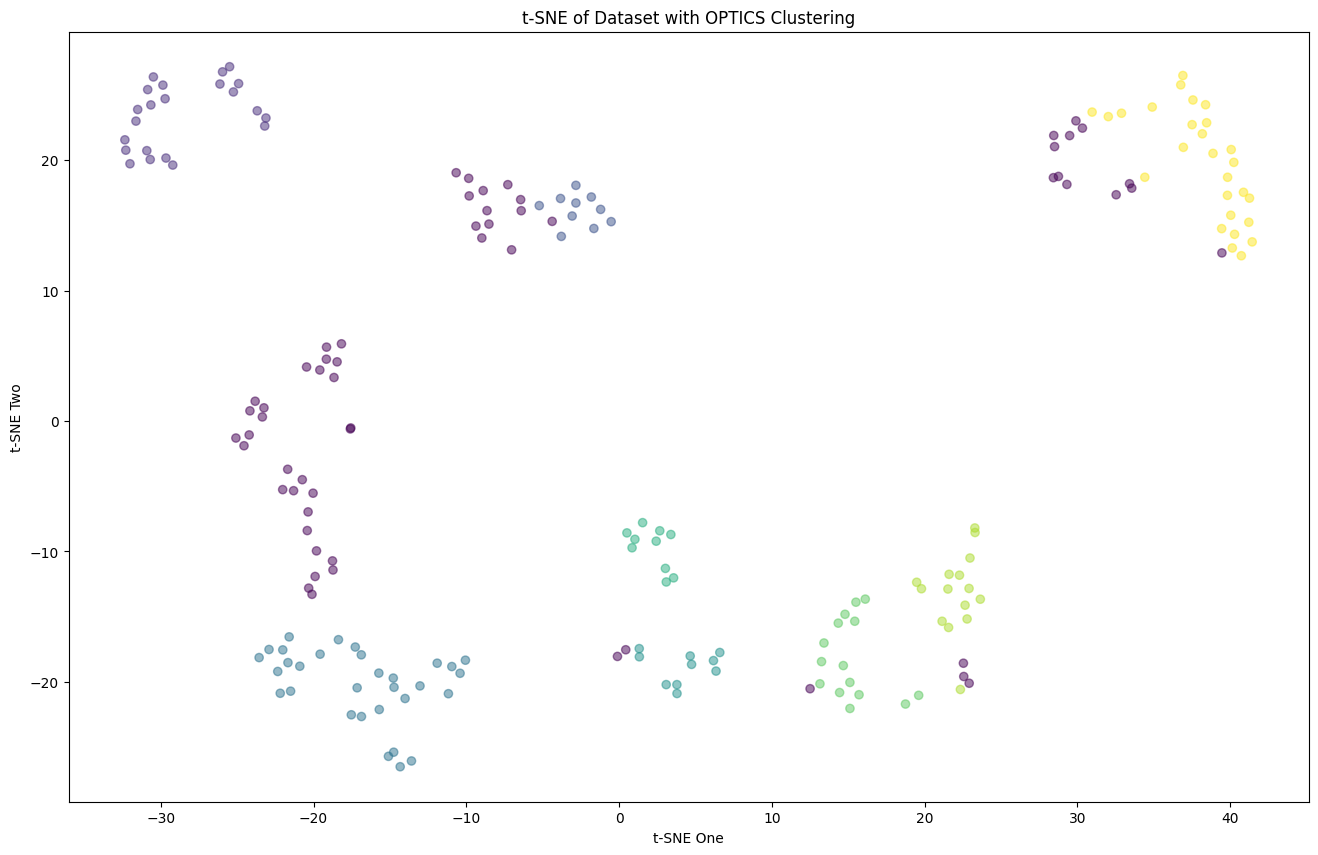

In [60]:
from sklearn.cluster import OPTICS
data_optics = df.copy() # already preprocessed
# apply clustering algorithm
optics = OPTICS(min_samples=10)
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result_optics = tsne.fit_transform(data_optics)
data_optics['tsne-one'] = tsne_result_optics[:,0]
data_optics['tsne-two'] = tsne_result_optics[:,1]
data_optics['cluster'] = optics.fit_predict(data_optics[['tsne-one','tsne-two']])
plt.figure(figsize=(16,10))
plt.scatter(data_optics['tsne-one'], data_optics['tsne-two'], alpha=0.5, c=data_optics['cluster'], cmap='viridis')
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('t-SNE of Dataset with OPTICS Clustering')
plt.show()

In [61]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_clustering(predicted_labels, data):
    # Filter out noise points (labeled as -1) for silhouette score calculation
    if -1 in predicted_labels:
        non_noise_indices = predicted_labels != -1
        if np.sum(non_noise_indices) > 1: # Silhouette score requires at least 2 labels
            silhouette = silhouette_score(data[non_noise_indices], predicted_labels[non_noise_indices])
        else:
            silhouette = -1 # Not enough points to calculate
    else:
        silhouette = silhouette_score(data, predicted_labels)
    
    chs = calinski_harabasz_score(data, predicted_labels)
    return silhouette, chs

# Evaluate K-Medoids
kmedoids_scores = evaluate_clustering(data_kmedoids['kmedoids_cluster'].values, data_kmedoids.drop(columns=['tsne-one', 'tsne-two', 'kmedoids_cluster']))

# Evaluate KMeans
kmeans_scores = evaluate_clustering(data_kmeans['cluster'].values, data_kmeans.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# Evaluate HDBSCAN
hdbscan_scores = evaluate_clustering(data_hdbscan['cluster'].values, data_hdbscan.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# Evaluate GMM
gmm_scores = evaluate_clustering(data_gmm['cluster'].values, data_gmm.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

# Evaluate OPTICS
optics_scores = evaluate_clustering(data_optics['cluster'].values, data_optics.drop(columns=['tsne-one', 'tsne-two', 'cluster']))

print("K-Medoids Scores (Silhouette, Calinski-Harabasz):", kmedoids_scores)
print("KMeans Scores (Silhouette, Calinski-Harabasz):", kmeans_scores)
print("HDBSCAN Scores (Silhouette, Calinski-Harabasz):", hdbscan_scores)
print("GMM Scores (Silhouette, Calinski-Harabasz):", gmm_scores)
print("OPTICS Scores (Silhouette, Calinski-Harabasz):", optics_scores)

K-Medoids Scores (Silhouette, Calinski-Harabasz): (0.37994153090393, 141.36488261954977)
KMeans Scores (Silhouette, Calinski-Harabasz): (0.3479679832706233, 136.15315717765182)
HDBSCAN Scores (Silhouette, Calinski-Harabasz): (0.28359036097646934, 86.22142243563782)
GMM Scores (Silhouette, Calinski-Harabasz): (0.2833751066685717, 106.83312468654161)
OPTICS Scores (Silhouette, Calinski-Harabasz): (0.37725334351631956, 47.574817132299195)
